In [37]:
#creating the environment down here
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 11:43:00 2022

@author: Sourav
"""
import numpy as np
class River_Swim:
    def __init__(self,nS=6,nA=2):
        self.nS = nS;
        self.nA = nA;
    def gen_probability(self):
        P = np.zeros((self.nA,self.nS,self.nS));
        P[0,0,0],P[0,0,1] = 0.9,0.1
        P[1,self.nS-1,self.nS-1],P[1,self.nS-1,self.nS-2] = 0.6,0.4
        for i in range(1,self.nS-1):
            P[0,i,i-1],P[0,i,i],P[0,i,i+1] = 0.3,0.6,0.1
            P[1,self.nS-i-1,self.nS-i],P[1,self.nS-i-1,self.nS-i-1],P[1,self.nS-i-1,self.nS-i-2] = 0.3,0.6,0.1
        P[0,self.nS-1,self.nS-1],P[0,self.nS-1,self.nS-2] = 0.7,0.3
        P[1,0,0],P[1,0,1] = 0.7,0.3
        #print(P)
        #print("Reward function");
        return P;
    def gen_expected_reward(self):
        R = np.zeros((self.nA,self.nS));
        R[0,0] = 1
        R[1,self.nS-1] = 0.82
        #print(R);
        return R;
'''nS = 6;
nA=2;
obj = River_Swim(nS,nA);
print("Probability matrix");
print(obj.gen_probability());
print("Reward Matrix");
print(obj.gen_expected_reward());'''

'nS = 6;\nnA=2;\nobj = River_Swim(nS,nA);\nprint("Probability matrix");\nprint(obj.gen_probability());\nprint("Reward Matrix");\nprint(obj.gen_expected_reward());'

In [38]:
import numpy as np
#from River_swim_env_create_new_env import River_Swim
class beh_pol_sd:
    def __init__(self,P,policy,nS,nA):
        self.P = P
        self.policy = policy
        self.nS = nS;
        self.nA = nA;
    
    def onehot(self):
        pol = np.zeros((self.nS,self.nA));
        for i in range(self.nS):
            pol[i][int(self.policy[i])]=1;
        return pol;
    def find_transition_matrix(self,onehot_encode=1):
        if(onehot_encode==1):
            self.policy = self.onehot()
        T_s_s_next = np.zeros((self.nS,self.nS));
        for s in range(self.nS):
            for s_next in range(self.nS):
                for a in range(self.nA):
                    #print(s,s_next,a);
                    #print(T[a,s,s_next]);
                    T_s_s_next[s,s_next]+=self.P[a,s,s_next]*self.policy[s,a];
        return T_s_s_next;
    def state_distribution_simulated(self,onehot_encode=1):
        P_policy = self.find_transition_matrix(onehot_encode)
        #print(P_policy);
        P_dash = np.append(P_policy - np.eye(self.nS),np.ones((self.nS,1)),axis=1);
        #print(P_dash);
        P_last = np.linalg.pinv(np.transpose(P_dash))[:,-1]
        return P_last;

In [39]:
def one_hot(target_policy,nS,nA):
    tp=np.zeros((nS,nA));
    for j in range(nS):
        tp[j][int(target_policy[j])] = 1;
    return np.array(tp);

In [40]:
nS,nA = 6,2
gamma = 1
mr_obj = River_Swim();
P,R = mr_obj.gen_probability(),mr_obj.gen_expected_reward()

In [41]:
T,runs = 100000,5
alpha = 0.1;
start = 0;
gamma = 0.9;
values = np.zeros((T,runs))
optimal = 0.6733169818431697
for run in range(runs):
    Q_table = np.random.random((nS,nA));
    state = start
    for t in range(T):
        if(np.random.random()<0.1):
            action = np.random.choice(nA);
        else:
            action = np.argmax(Q_table[state,:]);
        next_state = np.argmax(np.random.multinomial(1,P[action,state,:]));
        Q_table[state,action] = Q_table[state,action] + alpha*(R[action,action]+gamma * np.max(Q_table[next_state,:])-Q_table[state,action])
        policy = np.array([np.argmax(Q_table[state,:]) for state in range(nS)]);
        policy = one_hot(policy,nS,nA);
        #print(policy);
        #input();
        sd = beh_pol_sd(P, policy, nS, nA).state_distribution_simulated(0)
        values[t,run] = sum([R[np.argmax(Q_table[state,:]),state]*sd[state] for state in range(nS)]) 
        state = next_state

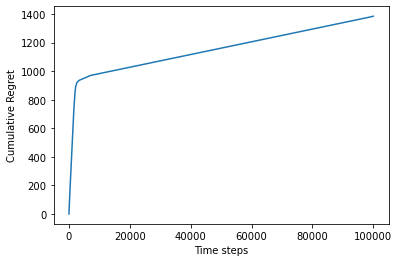

In [43]:
cost_avg1 = np.mean(values,axis = 1)
from matplotlib import pyplot as plt
plt.figure();
plt.plot(np.abs(np.cumsum(cost_avg1)-optimal*np.arange(1,T+1)));
plt.xlabel('Time steps');
plt.ylabel('Cumulative Regret');
#plt.legend(['Off_policy_algo1','Q_learning','Pmu approach']);
#plt.show();

(100000, 5)


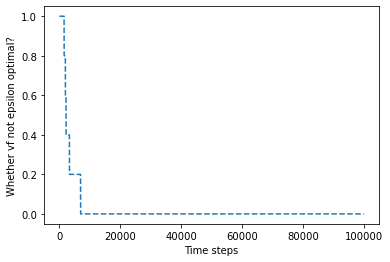

In [46]:
eps = 0.01
data1 = np.array([np.where(np.abs(values[i]-optimal)>eps,1,0) for i in range(T)]);
print(data1.shape)
cost_avg1 = np.array([np.mean([data1[i][run] for run in range(runs)])for i in range(T)])
plt.figure();
plt.plot(cost_avg1,linestyle='dashed');
#plt.title("Comparison with Q_learning(for riverswim)_eps_"+str(eps));
plt.xlabel('Time steps');
plt.ylabel('Whether vf not epsilon optimal?');
#plt.legend(['Off_policy_algo1','Q_learning','Pmu method']);

In [42]:
Q_table

array([[9.99999971, 8.99999956],
       [9.99999968, 8.9999989 ],
       [9.99999649, 8.99999397],
       [9.99998544, 8.99993659],
       [9.99995034, 8.97297451],
       [9.99982682, 7.96392378]])